In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp

<IPython.core.display.Javascript object>

In [5]:
train_cfg = {'dataset' : {'dirpath': '../data/', 
                          'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}
            }
train_data = fairgp.make_data(train_cfg)

# test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126', 'ssp245', 'ssp370', 'ssp585']}}
# test_data = plaingp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [30]:
def get_forcing_posterior(scenario_key):
    test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': [scenario_key]}}
    test_scenarios = fairgp.make_data(test_cfg).scenarios
    test_scenarios[0].name = test_scenarios[0].name + '-test'
    with torch.no_grad():
        posterior_F = fairgpmodel.forcing_posterior(test_scenarios)
    mF = fairgpmodel._compute_forcing_mean(test_scenarios)
    posterior_mean = posterior_F.mean
    posterior_lb, posterior_ub = posterior_F.confidence_region()
    output = {'time': test_scenarios.timesteps,
              'FaIR': mF,
              'mean': posterior_mean,
              'lb': posterior_lb,
              'ub': posterior_ub}
    return output

In [41]:
scenario_keys = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
posteriors = {key: get_forcing_posterior(key) for key in scenario_keys}

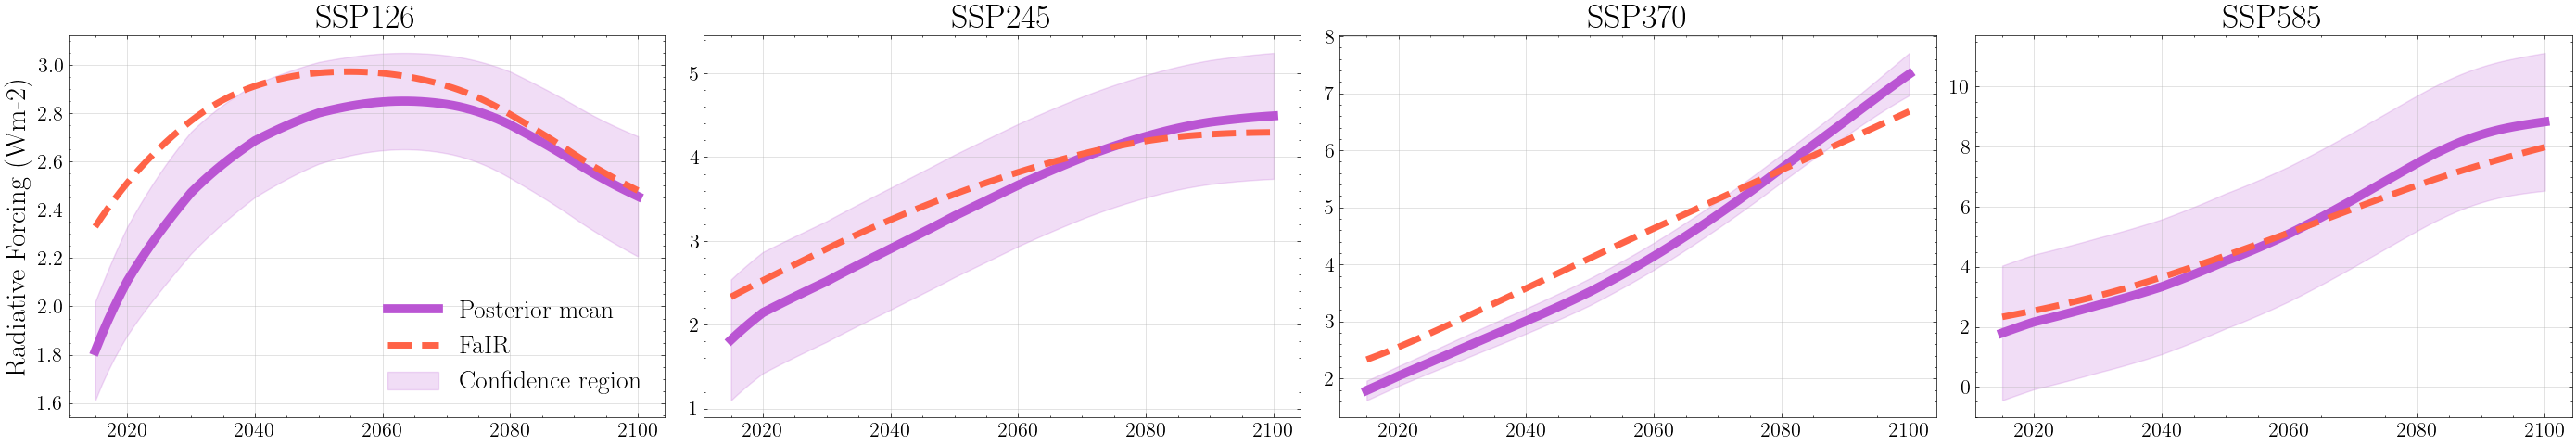

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(28, 5))

for i, key in enumerate(scenario_keys):
    posterior = posteriors[key]
    ax[i].plot(posterior['time'], posterior['mean'], color='mediumorchid', lw=7, label='Posterior mean')
    ax[i].plot(posterior['time'], posterior['FaIR'], color='tomato', ls='--', lw=5, label='FaIR')
    ax[i].fill_between(posterior['time'], posterior['lb'], posterior['ub'], alpha=0.2, color='mediumorchid', label='Confidence region')
    ax[i].tick_params(labelsize=16)
    ax[i].grid(alpha=0.5)
    ax[i].set_title(key.upper(), fontsize=26)

ax[0].set_ylabel('Radiative Forcing (Wm-2)', fontsize=22)
ax[0].legend(loc='lower right', fontsize=20)

plt.tight_layout()
plt.savefig('SSPs-forcing-posteriors.png', dpi=300)
plt.show()